In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import logging
from scipy.stats import rankdata
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import kendalltau
import time
import pickle
import shap
from tabulate import tabulate
from matplotlib.ticker import MaxNLocator
from generating_lirme_exs import random_exp

2024-03-31 18:56:15.429533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-31 18:56:15.647154: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-31 18:56:15.653223: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-31 18:56:15.653242: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [3]:
np.random.seed(42)

In [4]:
_name_features = [str(i + 1) for i in range(0, 100)]
df_test = pd.read_csv("./test_yahoo.csv")

In [5]:
def calculate_metrics(gam_explanations, lime_explanations, k_top):
    """Calculates the rbo and the overlap metrics for two set of explanations

    Args:
        gam_explanations: ndarray of subscores from GAM model
        lime_explanations: ndarray of subscores from LIME
    Returns:
       rbo (float) and overlap list (floats)
    """

    ranked_GAM = rankdata([-1 * i for i in gam_explanations]).astype(int) - 1
    ranked_LIME = rankdata([-1 * i for i in lime_explanations]).astype(int) - 1
    rbo_metric = rbo(ranked_GAM, ranked_LIME, k_top)
    overlap_metric = iter_overlap(ranked_GAM, ranked_LIME)
    
    return rbo_metric, overlap_metric
    
def rbo(list1, list2, p=0.9):
    """Calculates the rbo score for two equal sized ranks

    Args:
        list1: list of ranked values (integers)
        list2: list of ranked values (integers). Same length as list1
        p: weight assigned to items at different positions in the ranked lists, ranges [0,1]
    Returns:
       rbo (float)
    """
    # tail recursive helper function
    def helper(ret, i, d):
        l1 = set(list1[:i]) if i < len(list1) else set(list1)
        l2 = set(list2[:i]) if i < len(list2) else set(list2)
        a_d = len(l1.intersection(l2)) / i
        term = math.pow(p, i) * a_d
        if d == i:
            return ret + term
        return helper(ret + term, i + 1, d)

    k = max(len(list1), len(list2))
    x_k = len(set(list1).intersection(set(list2)))
    summation = helper(0, 1, k)

    return ((float(x_k) / k) * math.pow(p, k)) + ((1 - p) / p * summation)

def iter_overlap(list1, list2):
    """Calculates the % of overlap for two equal sized lists of ranked values in incremental sets
    of five, from 0 to number features

    Args:
        list1: list of ranked values (integers)
        list2: list of ranked values (integers). Same length as list1
    Returns:
       List of floats
    """
    list_overlap = []
    for x in range(5, len(_name_features) + 5, 5):
        included_values = [i for i in range(x)]
        indices1 = np.where(np.isin(list1, included_values))[0]
        indices2 = np.where(np.isin(list2, included_values))[0]
        inter = np.size(np.intersect1d(indices1, indices2))
        list_overlap.append(inter / x)
    return list_overlap

def get_auc(exp):
    #cutoffs = np.linspace(0.05, 0.45, 10)
    cutoffs = range(5, len(_name_features) + 5, 5)
    auc = {}
    temp = np.array(exp).mean(axis=1)
    auc_ = 0
    for k in range(1, len(cutoffs) - 1):
        x = cutoffs[k] - cutoffs[k - 1]
        y = temp[k] + temp[k-1]
        auc_ += y / ( 2 * x)
    return auc_

In [6]:
#std_features = df_test.std().iloc[2:].rank(ascending=False).values
std_features = df_test.std().iloc[2:].values

In [7]:
sample_sizes = [500, 1000, 2000, 3000, 5000]

eval_result = {}
for s_size in sample_sizes: 
    eval_result[s_size] = {f'overlap_{s_size}': {}, f'rbo_{s_size}': {}}#, f'corr_{s_size}': {}}

In [8]:
exp_names = ['lirme', 'exs_top_k', 'top_k_rank', 'exs_score', 'lime', 'shap', 'top_k_rank', 'random']

In [9]:
queries = [28587, 23068, 28700, 24240, 23890, 28483, 23132, 29379, 23022, 24923, 25000, 29889, 25191, 25207, 25226, 28035, 28203, 28670, 28286, 28276]

In [10]:
all_exps = {}

for s_size in sample_sizes: 
    all_exps[s_size] = {}
    
    laura_exps = pickle.load( open( f"./result/laura_exps_{s_size}_v2.p", "rb" ) )
    laura_exps_smote = pickle.load( open( f"./result/laura_exps_{s_size}_v3.p", "rb" ) )

    #laura_exps = pickle.load( open( f"./laura_exps_{s_size}_v2_rank_2.p", "rb" ) )
    #laura_exps_smote = pickle.load( open( f"./laura_exps_{s_size}_v3_rank_2.p", "rb" ) )
    
    #queries_list = list(our_exps.keys())

    for k in laura_exps[s_size].keys(): 
        if k not in all_exps.keys():
            all_exps[s_size][k] = []
        all_exps[s_size][k] =  laura_exps[s_size][k]['exp']

    for k in list(laura_exps_smote[s_size].keys()): 
        if f'{k}_original' not in all_exps.keys():
            all_exps[s_size][f'{k}_original'] = []
        all_exps[s_size][f'{k}_original'] =  laura_exps_smote[s_size][k]['exp']

In [11]:
all_gt = []
    
for i in range(len(laura_exps[s_size]['gaussian']['gt'])):
    all_gt.append(laura_exps[s_size]['gaussian']['gt'][i])

In [12]:
queries = [28587, 23068, 28700, 24240, 23890, 28483, 23132, 29379, 23022, 24923, 25000, 29889, 25191, 25207, 25226, 28035, 28203, 28670, 28286, 28276]

In [13]:
def normalize(v):
    epsilon = np.finfo(np.float32).eps
    sum_v = np.sum(v) 
    return v / (sum_v + epsilon)

In [14]:
eval_result = {}

for s_size in all_exps.keys():
    #print(s_size)
    eval_result[s_size] = {f'rbo_{s_size}': {}, f'overlap_{s_size}': {}}
    for e in all_exps[s_size].keys():
        temp_overlap = []
        temp_rbo = []
        
        for i in range(len(all_exps[s_size][e])): 
            exp_val = all_exps[s_size][e][i].reshape(len(_name_features))
            gt_val = all_gt[i].reshape(len(_name_features))
            rbo_m, overlap_m = calculate_metrics(normalize(gt_val), normalize(exp_val), 0.95)
            temp_rbo.append(rbo_m)
            temp_overlap.append(overlap_m)
        
        eval_result[s_size][f'rbo_{s_size}'][e] = np.mean(temp_rbo) 
        eval_result[s_size][f'overlap_{s_size}'][e] =  get_auc(np.array(temp_overlap))

In [15]:
final_result = pd.concat([pd.DataFrame(eval_result[500]), 
           pd.DataFrame(eval_result[1000]),
           pd.DataFrame(eval_result[2000]),
           pd.DataFrame(eval_result[3000]),
           pd.DataFrame(eval_result[5000])], axis=1)

In [16]:
final_result.round(2).T.style.highlight_max(axis=1)

,smote,gaussian,lhs,dlime,smote_original,gaussian_original,lhs_original,dlime_original
rbo_500,0.200000,0.190000,0.230000,0.200000,0.190000,0.210000,0.200000,0.200000
overlap_500,2.060000,2.230000,2.280000,2.130000,2.070000,2.210000,2.230000,2.140000
rbo_1000,0.200000,0.200000,0.210000,0.190000,0.220000,0.210000,0.190000,0.220000
overlap_1000,2.100000,2.270000,2.280000,2.240000,2.090000,2.270000,2.270000,2.260000
rbo_2000,0.180000,0.190000,0.200000,0.220000,0.200000,0.210000,0.230000,0.210000
overlap_2000,2.110000,2.290000,2.280000,2.280000,2.120000,2.300000,2.300000,2.260000
rbo_3000,0.180000,0.220000,0.190000,0.210000,0.180000,0.210000,0.230000,0.220000
overlap_3000,2.120000,2.290000,2.300000,2.290000,2.130000,2.300000,2.300000,2.270000
rbo_5000,0.180000,0.200000,0.200000,0.220000,0.190000,0.190000,0.230000,0.210000
overlap_5000,2.130000,2.310000,2.290000,2.300000,2.130000,2.310000,2.310000,2.290000


In [17]:
final_result.T.iloc[-2:, :]

,smote,gaussian,lhs,dlime,smote_original,gaussian_original,lhs_original,dlime_original
rbo_5000,0.179475,0.200308,0.199602,0.222226,0.188767,0.194549,0.225086,0.205764
overlap_5000,2.133432,2.306268,2.289241,2.295807,2.128680,2.309830,2.306540,2.286745


In [18]:
all_exp_names = list(final_result.index)

In [19]:
print(tabulate(final_result.round(2), tablefmt='latex_raw'))

\begin{tabular}{lrrrrrrrrrr}
\hline
 smote             & 0.2  & 2.06 & 0.2  & 2.1  & 0.18 & 2.11 & 0.18 & 2.12 & 0.18 & 2.13 \\
 gaussian          & 0.19 & 2.23 & 0.2  & 2.27 & 0.19 & 2.29 & 0.22 & 2.29 & 0.2  & 2.31 \\
 lhs               & 0.23 & 2.28 & 0.21 & 2.28 & 0.2  & 2.28 & 0.19 & 2.3  & 0.2  & 2.29 \\
 dlime             & 0.2  & 2.13 & 0.19 & 2.24 & 0.22 & 2.28 & 0.21 & 2.29 & 0.22 & 2.3  \\
 smote_original    & 0.19 & 2.07 & 0.22 & 2.09 & 0.2  & 2.12 & 0.18 & 2.13 & 0.19 & 2.13 \\
 gaussian_original & 0.21 & 2.21 & 0.21 & 2.27 & 0.21 & 2.3  & 0.21 & 2.3  & 0.19 & 2.31 \\
 lhs_original      & 0.2  & 2.23 & 0.19 & 2.27 & 0.23 & 2.3  & 0.23 & 2.3  & 0.23 & 2.31 \\
 dlime_original    & 0.2  & 2.14 & 0.22 & 2.26 & 0.21 & 2.26 & 0.22 & 2.27 & 0.21 & 2.29 \\
\hline
\end{tabular}


In [20]:
eval_result_bbox = {}

for s_size in all_exps.keys():
    #print(s_size)
    eval_result_bbox[s_size] = {'rbo': {}, 'overlap': {}}
    for e in all_exps[s_size].keys():
        temp_overlap = []
        temp_rbo = []
        
        for i in range(len(all_exps[s_size][e])): 
            exp_val = all_exps[s_size][e][i].reshape(len(_name_features))
            gt_val = all_gt[i].reshape(len(_name_features))
            rbo_m, overlap_m = calculate_metrics(normalize(gt_val), normalize(exp_val), 0.95)
            temp_rbo.append(rbo_m)
            temp_overlap.append(np.mean(overlap_m))
        
        eval_result_bbox[s_size]['rbo'][e] = temp_rbo
        eval_result_bbox[s_size]['overlap'][e] =  temp_overlap

In [21]:
key_names = ['smote', 'gaussian', 'lhs', 'dlime']

In [22]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    return ax

In [23]:
exp_name_figure = {
    'smote': 'Smote',
     'gaussian':'Gaussian',
     'lhs': 'LHS',
     'dlime': 'DLIME',
     'lirme': 'LIRME',
     'exs_top_k': 'EXS (B)',
     'top_k_rank': 'EXS (R)',
     'exs_score': 'EXS (S)',
     'lime': 'LIME',
     'shap': 'SHAP',
     'random': 'Random'
}

In [24]:
key_names_title = ['SMOTE', 'GAUSSIAN', 'LHS', 'DLIME']

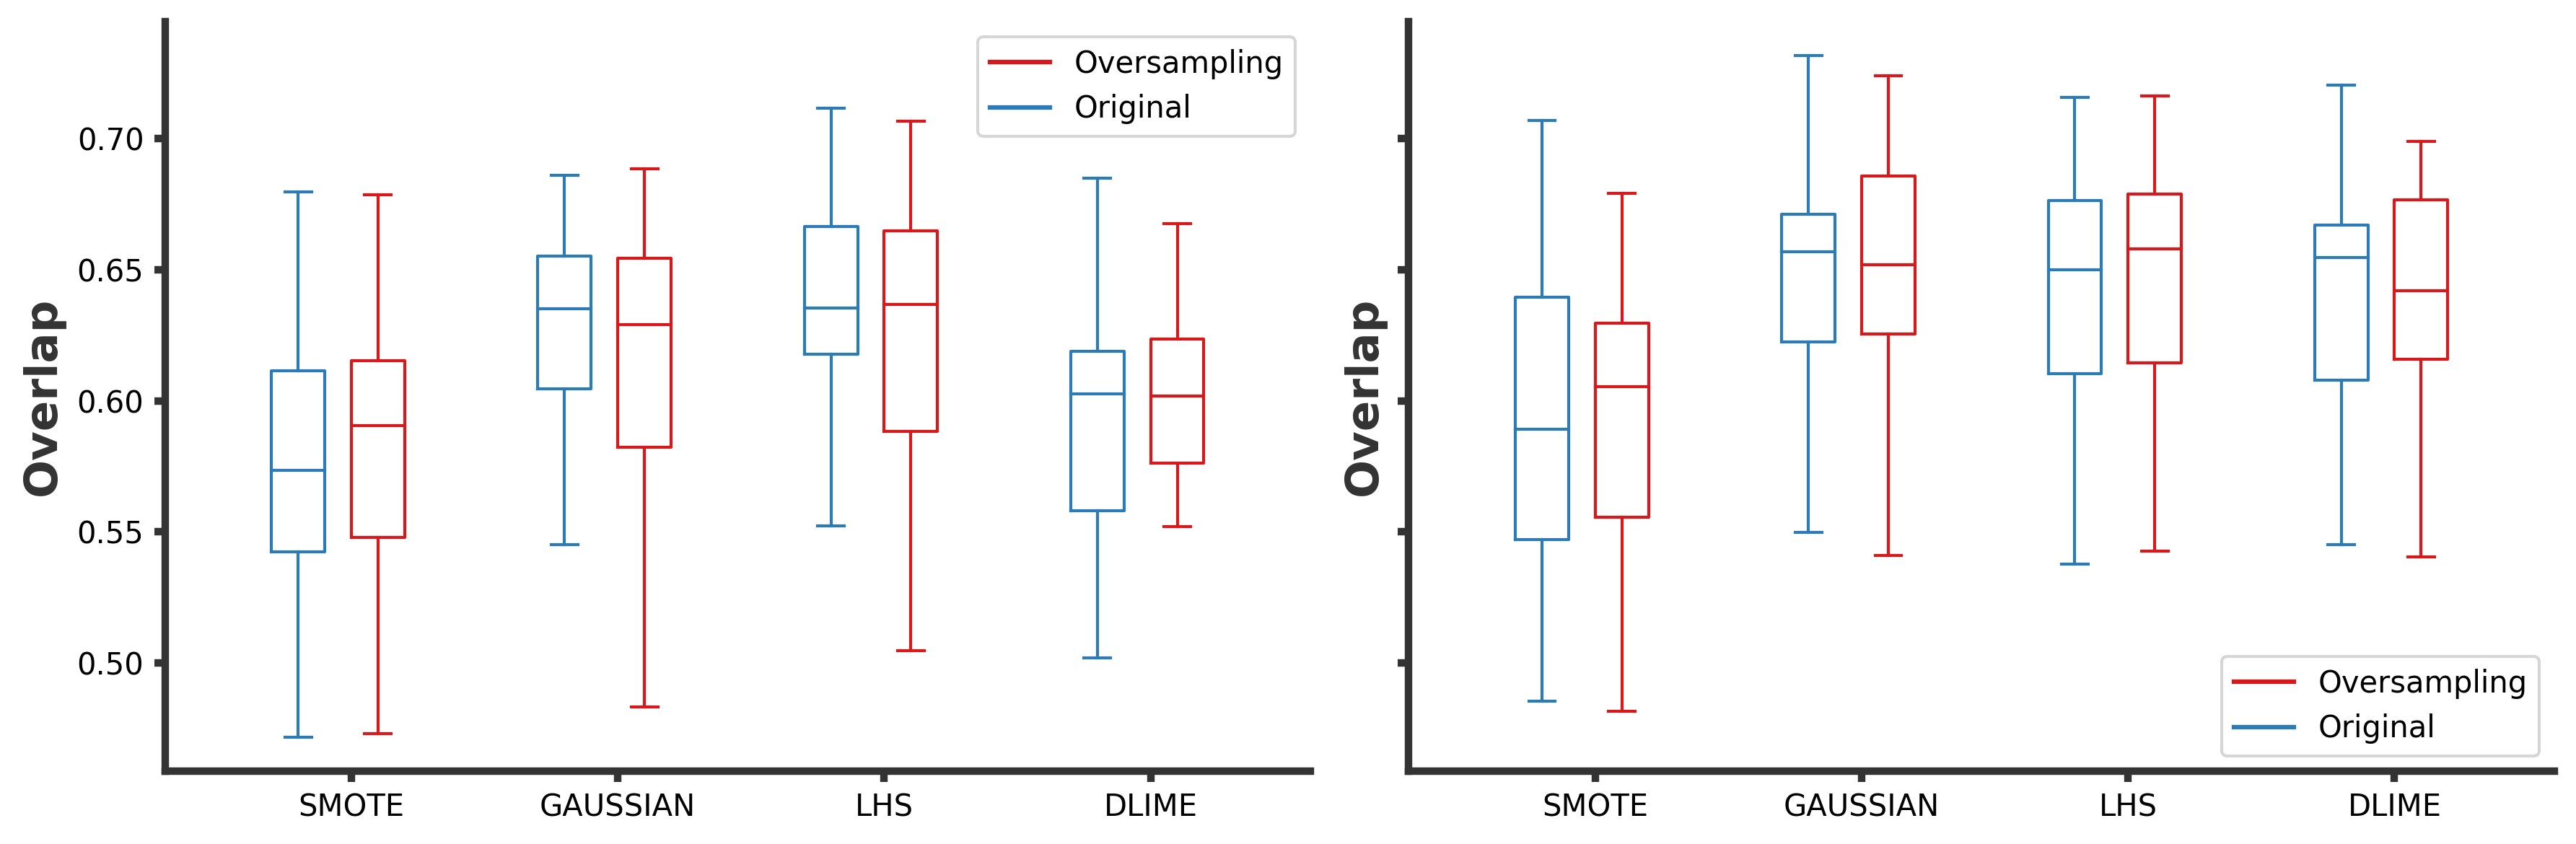

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300, sharey=True)

s_size_selected = [500, 3000]
titles = [f'Sample Size: {s_size_selected[0]}', f'Sample Size: {s_size_selected[1]}']

for i in range(2):
    s_size = s_size_selected[i]
    all_results = []
    all_results_original = []
    
    for k in key_names: 
        all_results.append(eval_result_bbox[s_size]['overlap'][k])
        all_results_original.append(eval_result_bbox[s_size]['overlap'][f'{k}_original'])
    
    # first boxplot pair
    bp = ax[i].boxplot(all_results, positions = np.arange(len(all_results)), widths = 0.2, sym='')
    set_box_color(bp, '#2C7BB6')

    ax[i].plot([], c='#D7191C', label='Oversampling')
    ax[i].plot([], c='#2C7BB6', label='Original')


    # second boxplot pair
    bp = ax[i].boxplot(all_results_original, positions = np.arange(len(all_results_original)) + 0.3, sym='', widths = 0.2)
    set_box_color(bp, '#D7191C')
    ax[i].legend()
    ax[i].set_xticks(np.arange(len(key_names)) + 0.2)
    ax[i].set_xticklabels(key_names_title)

    ax[i] = process_ax(ax[i])
    ax[i].set_ylabel('Overlap')
plt.tight_layout()
plt.savefig('./smote_no_smote_rank_10.pdf')
plt.show()